# Introduction

### Imports

In [87]:
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from scipy import stats
from statsmodels.tools.eval_measures import mse, rmse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from sklearn.model_selection import cross_validate

%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li></ul></li><li><span><a href="#Assignment" data-toc-modified-id="Assignment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assignment</a></span></li></ul></div>

# Assignment

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()


In [7]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [8]:
# combine related variables within feature list

housing_df['total_sf'] = housing_df.totalbsmtsf + housing_df.grlivarea + housing_df.garagearea 
+ housing_df.wooddecksf + housing_df.openporchsf + housing_df.poolarea

housing_df['total_fullbaths'] = housing_df.bsmtfullbath + housing_df.fullbath
housing_df['total_halfbaths'] = housing_df.bsmthalfbath + housing_df.halfbath

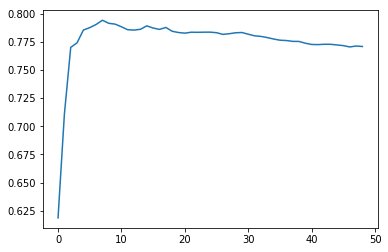

In [43]:
feature_list = ['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'grlivarea', 'garagearea']

train_x, test_x, train_y, test_y = train_test_split(housing_df[feature_list], housing_df['saleprice'], test_size=.2)

knn_scores = {}
for num in range(1,50):
    knn = KNeighborsRegressor(n_neighbors=num, weights='distance')
    knn.fit(train_x, train_y)
    knn_scores[num] = knn.score(test_x, test_y)

plt.plot(knn_scores.values())
plt.show()



In [44]:
print('Best K val: {} .. Score: {}'.format(max(knn_scores, key=knn_scores.get), knn_scores[8]))

Best K val: 8 .. Score: 0.7940255768345891


In [54]:
def model_results(model_list, data, target):
    scoring = ['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_absolute_error',
               'train_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error']
    results_df = pd.DataFrame(columns=[score for score in scoring], index=[
                              name for name in model_list])
    for name, model in model_list.items():
        model_results = cross_validate(model, data, target, cv=5, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
                                       return_train_score=False)
        scoring = list(model_results.keys())
        # convert error to positive and generate RMSE
        for score in scoring:
            if (score == 'test_neg_mean_squared_error') or (score == 'train_neg_mean_squared_error'):
                #model_results['root_'+score[:5]+score[9:]] = np.sqrt(model_results[score] * -1)
                model_results['root_'+score[:5]+score[9:]
                              ] = np.sqrt(model_results[score] * -1).mean()
                del model_results[score]
            elif (score == 'test_neg_mean_absolute_error') or (score == 'train_neg_mean_absolute_error'):
                model_results[score[:5]+score[9:]
                              ] = (model_results[score] * -1).mean()
                del model_results[score]
            else:
                #model_results[score[:5]+score[9:]] = model_results[score] * -1
                model_results[score] = model_results[score].mean()
        model_df = pd.DataFrame(model_results, index=[name])

    return model_df

In [107]:
data = stats.zscore(housing_df[feature_list])
knn = KNeighborsRegressor(n_neighbors=8)

knn_dict = {'knn': knn}
knn = model_results(knn_dict, data, target)

knn

,fit_time,score_time,test_r2,test_mean_absolute_error,root_test_mean_squared_error
knn,0.001333,0.011412,0.811451,20961.788699,34341.504423


In [106]:
data = housing_df[feature_list]
target = housing_df['saleprice']

knn = KNeighborsRegressor(n_neighbors=8)
linear = LinearRegression()

#knn_dict = {'knn': knn}
#knn = model_results(knn_dict, data, target)
linear_dict = {'linear': linear}
linear = model_results(linear_dict, data, target)

linear

,fit_time,score_time,test_r2,test_mean_absolute_error,root_test_mean_squared_error
linear,0.003277,0.004242,0.761194,24163.296276,38446.293716


In [59]:
X = sm.add_constant(train_x)
results = sm.OLS(train_y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     612.7
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:18:30   Log-Likelihood:                -14008.
No. Observations:                1168   AIC:                         2.803e+04
Df Residuals:                    1161   BIC:                         2.807e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.166e+06   1.41e+05     -8.289      0.000   -1.44e+06    -8.9e+05
overallqual   2.022e+04   1355.928     14.914      0.000    1.76e+04    2.29e+04
yearbuilt      236.8770     55.543      4.265      0.000     127.900     345.854
yearremodadd   319.1981     73.573      4.339      0.000     174.847     463.549
totalbsmtsf     23.4032      3.282      7.130      0.000      16.963      29.843
grlivarea       49.3531      2.924     16.879      0.000      43.616      55.090
garagearea      50.3909      7.016      7.182      0.000      36.625      64.157
==============================================================================
Omnibus:                      388.037   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51629.162
Skew:                          -0.381   Prob(JB):                         0.00
Kurtosis:                      35.562   Cond. No.                     4.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With this specific training and testing set, the KNN model is the better model based on all metrics above. The difference between the model's metrics were reasonably significant. The KNN's RMSE was 4105 units larger than the linear's RMSE. This could mean that the linear model innaccurately predicted more high value houses than the linear model. Another possible reason is that the linear model's magnitude of high value errors for a small percentage  houses were substantial.

In favor of the KNN model, the KNN model's MAE was 3202 units smaller than the KNN model. This means that the KNN model outperformed the linear model even in predicting lower value houses.  In regards to R^2 score's, the KNN model'score was about 5% higher than the linear model. Both R^2 scores were in a reasonable range meaning that both models are unlikely to be suspectible to overfitting and underfitting.

One of the problems with KNN models is that the model assumes that the unit of measurements is constant across all features. In this particular dataset, the difference in scale between features were significantly large (e.g. square feet and total fullbaths). Standardizing the data made the distances between data points comparable between features. Before I standardized the data using z scores, the linear model outperformed the KNN to about half the degree that KNN outperformed the linear model. 